In [4]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from math import pi,log
import matplotlib as mpl    

# import basic plot tools
from qiskit.visualization import plot_histogram

# map to Statevector
from qiskit.quantum_info import Statevector


# Quantum Assignment

The goal of the assignment is to take the code we wrote in the previous class and convert it into Sticky Walk. Since the coin and shift operator are already implemented, all you need to do is add the oracle and modify a few function calls. 

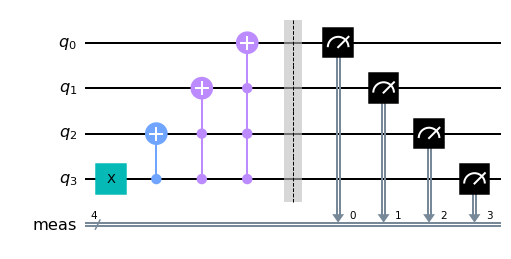

In [5]:
# qubit incrementation

# arg: n_adder is the number of qubits to be incremented

def increment(n_adder):
    
    qc = QuantumCircuit(n_adder)
    
    for i in range(n_adder-2):
        qc.mcx(list(range(i+1, n_adder)),i)
    
    qc.cx(n_adder-1, n_adder-2)
    qc.x(n_adder-1)
    
    U_inc = qc.to_gate()
    U_inc.name = "U$_{inc}$"
    
    return U_inc


def decrement(n_sub):
    
    qc = QuantumCircuit(n_sub)
    
    qc.x(n_sub-1)
    qc.cx(n_sub-1, n_sub-2)
    
    for i in range(n_sub-3, -1, -1):
        qc.mcx(list(range(i+1, n_sub)),i)
               
    U_dec = qc.to_gate()
    U_dec.name = "U$_{dec}$"
    
    return U_dec

qc = QuantumCircuit(4)

qc.append(decrement(4), [0,1,2,3])
qc.measure_all()

qc.decompose().draw('mpl')

In [6]:
def shift(n_dir, n_pos):
    
    half_n = math.ceil(n_pos/2)
    
    qr = QuantumRegister(n_dir+n_pos)
    q_dir = qr[:n_dir]
    q_pos = qr[n_dir:]
    
    qc = QuantumCircuit(qr)
    
    # if direction is 00 (RIGHT), increment right-most qubits
    qc.x(q_dir)
    qc.append(increment(half_n).control(2), q_dir+q_pos[half_n:])
    qc.x(q_dir)
    
    # if direction is 01 (DOWN), increment left-most qubits
    qc.x(q_dir[0])
    qc.append(increment(half_n).control(2), q_dir+q_pos[:half_n])
    qc.x(q_dir[0])
    
    # if direction is 10 (LEFT), decrement right-most qubits
    qc.x(q_dir[1])
    qc.append(decrement(half_n).control(2), q_dir+q_pos[half_n:])
    qc.x(q_dir[1])
    
    # if direction is 11 (UP), increment left-most qubits
    qc.append(decrement(half_n).control(2), q_dir+q_pos[:half_n])
    
    
    U_shift = qc.to_gate()
    U_shift.name = "U$_{shift}$"
    return U_shift

## Hints and help


The above (increment, decrement, and shift) do not need to be touched. The only code you will need to add / change is in the code of the walk itself. Please add/edit code in the commented location.

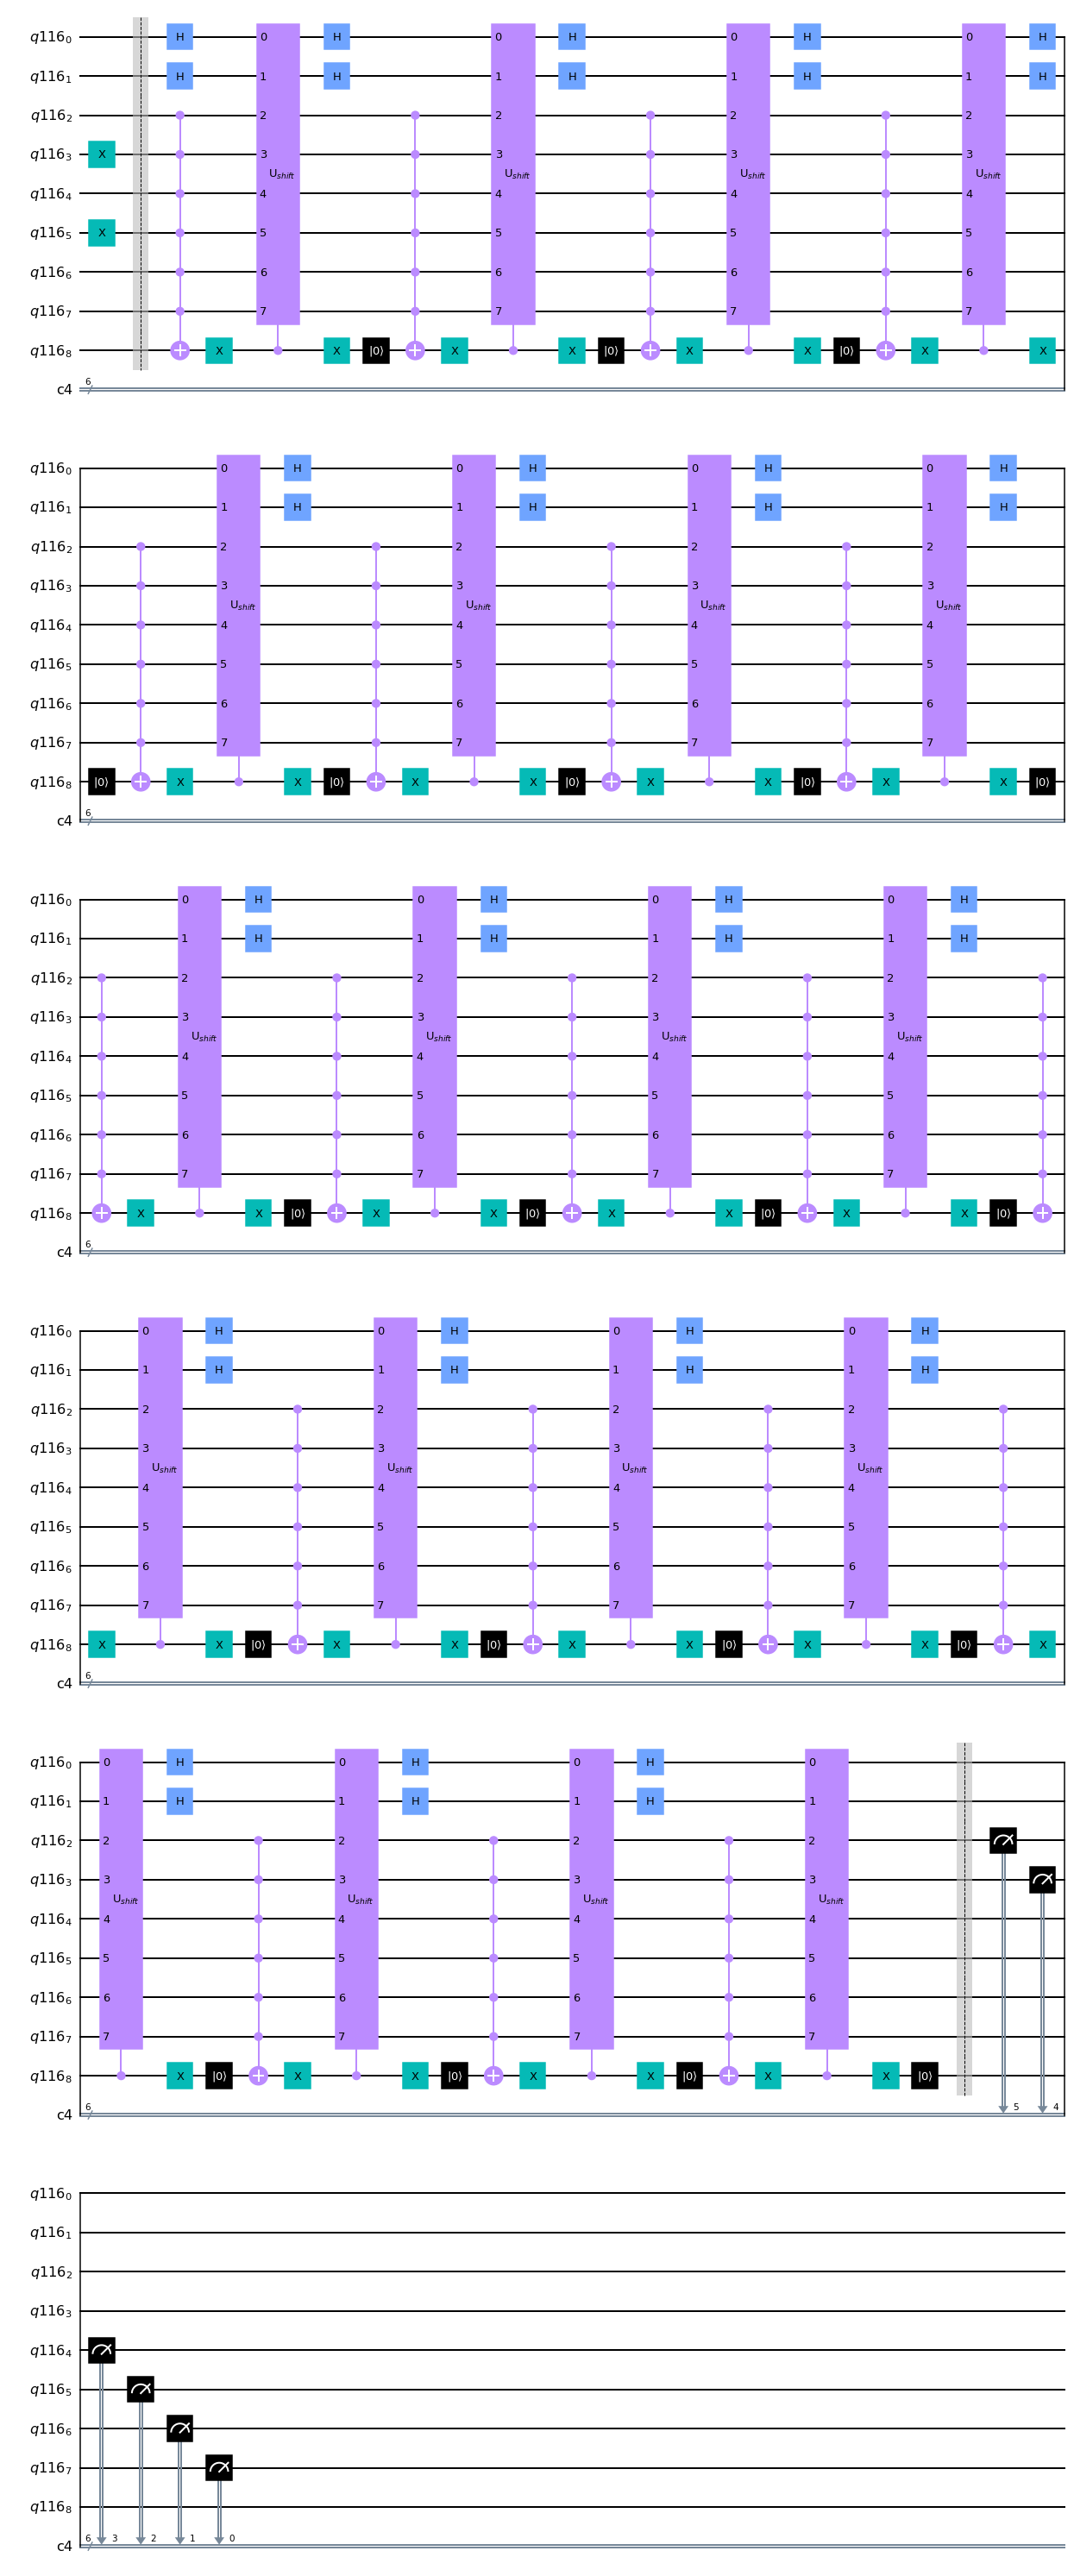

In [13]:
n_dir = 2 # number of qubits required to represent all directions
n_pos = 6 # number of qubits required to represent all positions.
iterations = 20

''' +1 added for ancilla. The ancilla qubit is set to |1> if |pos> is a target state,
    |0> otherwise. '''
qwalk_reg = QuantumRegister(n_dir+n_pos+1)

# allocating qubits
q_dir = qwalk_reg[:n_dir]
q_pos = qwalk_reg[n_dir:n_dir+n_pos]
q_anc = qwalk_reg[n_dir+n_pos]

# lists of indices
dir_ind = list(range(n_dir)) # [0,1]
pos_ind = list(range(n_dir+n_pos))[n_dir:] # [2,3,4,5,6,7]
anc_ind = [n_dir+n_pos] # 8

qwalk_circ = QuantumCircuit(qwalk_reg, ClassicalRegister(n_pos))

# starting state 010100
qwalk_circ.x(3)
qwalk_circ.x(5)
qwalk_circ.barrier()


# Add state harvesting
states = []

# setup iterations
for i in range(iterations):
    
    states.append(Statevector.from_instruction(qwalk_circ))
    
    # apply Hadamard coin
    for qubit in q_dir:
        qwalk_circ.h(qubit)
        
    ''' WRITE YOUR ORACLE HERE. You do not need to write a separate function.
        This will be a boolean oracle. (NOT A PHASE ORACLE)
        The target state is 111111. Use this information to set the ancilla accordingly.'''
    # Apply a controlled not to the ancilla qubit, controlled by the position register
    # The oracle is: O(|x>\otimes|y>) = |x>\otimes|y+f(x)>
    # With f(x_0) = 1, f(x) = 0 if x !=x_0
    # In our case, x_0 = 111111
    qwalk_circ.mcx(q_pos, q_anc)
    
    ''' END OF ORACLE'''
    
    '''Modify the shift operator call so that the walker only takes a step
       if they are not in a target state. ie. if in a target state, no shift
       is applied. '''
    # Apply a controlled shift depending on the ancilla qubit
    # If ancilla is 0, apply the shift, else don't apply the shift
    qwalk_circ.x(q_anc)
    qwalk_circ.append(shift(n_dir, n_pos).control(1), anc_ind + dir_ind + pos_ind)
    qwalk_circ.x(q_anc)
    # Resetting the ancilla qubit to a |0> state
    qwalk_circ.reset(q_anc)

states.append(Statevector.from_instruction(qwalk_circ))
qwalk_circ.barrier()

# measure position qubits only
qwalk_circ.measure(pos_ind, list(range(n_pos))[::-1]) # reversed to print in Big Endian form

qwalk_circ.draw('mpl')

## Plotting the historigram of probabilities

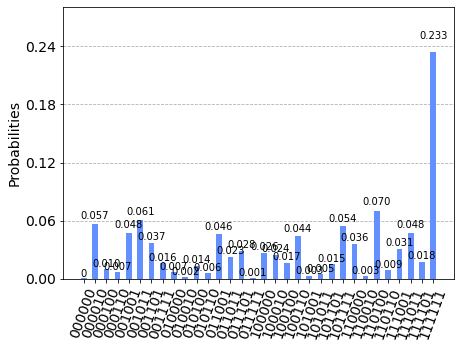

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(qwalk_circ, aer_sim)
qobj = assemble(transpiled_circuit)
results = aer_sim.run(qobj, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

## Plotting the walk step by step

Position qubits: {'010100': 1.0}
Data: [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


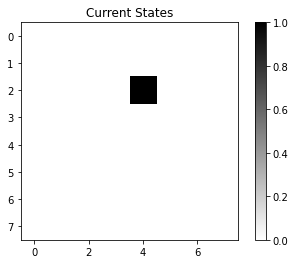

Position qubits: {'001100': 0.25, '010011': 0.25, '010101': 0.25, '011100': 0.25}
Data: [[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.25 0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


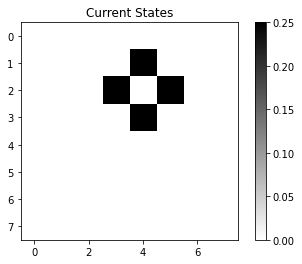

Position qubits: {'000100': 0.0625, '001011': 0.125, '001101': 0.125, '010010': 0.0625, '010100': 0.25, '010110': 0.0625, '011011': 0.125, '011101': 0.125, '100100': 0.0625}
Data: [[0.     0.     0.     0.     0.0625 0.     0.     0.    ]
 [0.     0.     0.     0.125  0.     0.125  0.     0.    ]
 [0.     0.     0.0625 0.     0.25   0.     0.0625 0.    ]
 [0.     0.     0.     0.125  0.     0.125  0.     0.    ]
 [0.     0.     0.     0.     0.0625 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.    ]]


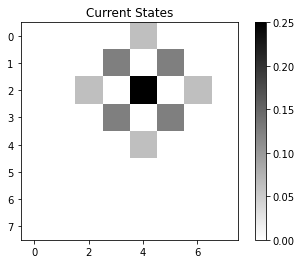

Position qubits: {'000011': 0.01563, '000101': 0.07813, '001010': 0.07813, '001100': 0.07812, '001110': 0.07813, '010001': 0.01563, '010011': 0.07813, '010101': 0.01562, '010111': 0.01562, '011010': 0.01562, '011100': 0.39062, '011110': 0.07812, '100011': 0.01563, '100101': 0.01562, '101100': 0.01562, '111100': 0.01563}
Data: [[0.      0.      0.      0.01563 0.      0.07813 0.      0.     ]
 [0.      0.      0.07813 0.      0.07812 0.      0.07813 0.     ]
 [0.      0.01563 0.      0.07813 0.      0.01562 0.      0.01562]
 [0.      0.      0.01562 0.      0.39062 0.      0.07812 0.     ]
 [0.      0.      0.      0.01563 0.      0.01562 0.      0.     ]
 [0.      0.      0.      0.      0.01562 0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.01563 0.      0.      0.     ]]


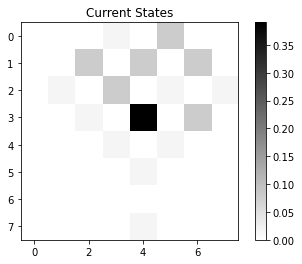

Position qubits: {'000010': 0.00781, '000100': 0.01563, '000110': 0.07031, '001001': 0.03906, '001011': 0.10938, '001101': 0.04687, '001111': 0.03906, '010000': 0.00781, '010010': 0.01563, '010100': 0.07813, '010110': 0.01562, '011001': 0.00781, '011011': 0.04687, '011101': 0.35937, '011111': 0.03906, '100010': 0.00781, '100100': 0.01563, '100110': 0.00781, '101011': 0.00781, '101101': 0.00781, '110100': 0.00781, '111011': 0.00781, '111101': 0.03906}
Data: [[0.      0.      0.00781 0.      0.01563 0.      0.07031 0.     ]
 [0.      0.03906 0.      0.10938 0.      0.04687 0.      0.03906]
 [0.00781 0.      0.01563 0.      0.07813 0.      0.01562 0.     ]
 [0.      0.00781 0.      0.04687 0.      0.35937 0.      0.03906]
 [0.      0.      0.00781 0.      0.01563 0.      0.00781 0.     ]
 [0.      0.      0.      0.00781 0.      0.00781 0.      0.     ]
 [0.      0.      0.      0.      0.00781 0.      0.      0.     ]
 [0.      0.      0.      0.00781 0.      0.03906 0.      0.     ]]


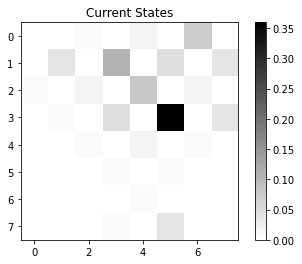

Position qubits: {'000001': 0.00391, '000011': 0.01953, '000101': 0.03516, '000111': 0.05078, '001000': 0.03516, '001010': 0.08203, '001100': 0.04688, '001110': 0.01953, '010001': 0.00391, '010011': 0.04688, '010101': 0.07813, '010111': 0.02734, '011000': 0.01953, '011010': 0.01953, '011100': 0.07812, '011110': 0.16016, '100001': 0.00391, '100011': 0.00391, '100101': 0.16016, '100111': 0.00391, '101010': 0.00391, '101100': 0.00391, '101110': 0.00391, '110011': 0.01172, '110101': 0.01953, '111010': 0.00391, '111100': 0.00391, '111110': 0.05078}
Data: [[0.      0.00391 0.      0.01953 0.      0.03516 0.      0.05078]
 [0.03516 0.      0.08203 0.      0.04688 0.      0.01953 0.     ]
 [0.      0.00391 0.      0.04688 0.      0.07813 0.      0.02734]
 [0.01953 0.      0.01953 0.      0.07812 0.      0.16016 0.     ]
 [0.      0.00391 0.      0.00391 0.      0.16016 0.      0.00391]
 [0.      0.      0.00391 0.      0.00391 0.      0.00391 0.     ]
 [0.      0.      0.      0.01172 0.      

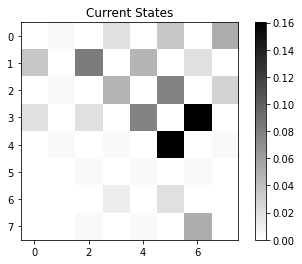

Position qubits: {'000000': 0.02637, '000010': 0.05859, '000100': 0.00684, '000110': 0.03516, '001001': 0.05078, '001011': 0.01758, '001101': 0.04883, '001111': 0.00391, '010000': 0.03516, '010010': 0.03809, '010100': 0.04688, '010110': 0.01465, '011001': 0.01953, '011011': 0.01758, '011101': 0.14258, '011111': 0.05078, '100000': 0.01074, '100010': 0.00391, '100100': 0.0459, '100110': 0.10547, '101001': 0.00195, '101011': 0.00391, '101101': 0.08203, '101111': 0.00195, '110010': 0.00293, '110100': 0.00391, '110110': 0.03418, '111001': 0.00195, '111011': 0.01953, '111101': 0.01953, '111111': 0.04883}
Data: [[0.02637 0.      0.05859 0.      0.00684 0.      0.03516 0.     ]
 [0.      0.05078 0.      0.01758 0.      0.04883 0.      0.00391]
 [0.03516 0.      0.03809 0.      0.04688 0.      0.01465 0.     ]
 [0.      0.01953 0.      0.01758 0.      0.14258 0.      0.05078]
 [0.01074 0.      0.00391 0.      0.0459  0.      0.10547 0.     ]
 [0.      0.00195 0.      0.00391 0.      0.08203 0. 

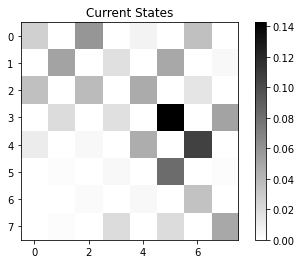

Position qubits: {'000001': 0.08034, '000011': 0.01874, '000101': 0.01976, '000111': 0.02284, '001000': 0.02284, '001010': 0.01771, '001100': 0.01976, '001110': 0.02592, '010001': 0.029, '010011': 0.04646, '010101': 0.04543, '010111': 0.0249, '011000': 0.01668, '011010': 0.01874, '011100': 0.01463, '011110': 0.02387, '100001': 0.01155, '100011': 0.01874, '100101': 0.25282, '100111': 0.08855, '101000': 0.00334, '101010': 0.00128, '101100': 0.02284, '101110': 0.03414, '110001': 0.00026, '110011': 0.00847, '110101': 0.01668, '110111': 0.02079, '111000': 0.0136, '111010': 0.02387, '111100': 0.00026, '111110': 0.03516}
Data: [[0.      0.08034 0.      0.01874 0.      0.01976 0.      0.02284]
 [0.02284 0.      0.01771 0.      0.01976 0.      0.02592 0.     ]
 [0.      0.029   0.      0.04646 0.      0.04543 0.      0.0249 ]
 [0.01668 0.      0.01874 0.      0.01463 0.      0.02387 0.     ]
 [0.      0.01155 0.      0.01874 0.      0.25282 0.      0.08855]
 [0.00334 0.      0.00128 0.      0.0

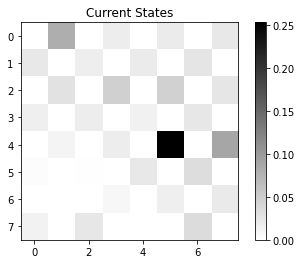

Position qubits: {'000000': 0.03208, '000010': 0.07418, '000100': 0.01258, '000110': 0.02182, '001001': 0.03568, '001011': 0.01001, '001101': 0.02336, '001111': 0.01104, '010000': 0.02284, '010010': 0.00847, '010100': 0.04646, '010110': 0.06391, '011001': 0.01104, '011011': 0.01514, '011101': 0.02233, '011111': 0.01104, '100000': 0.07007, '100010': 0.0095, '100100': 0.02695, '100110': 0.25898, '101001': 0.00282, '101011': 0.01104, '101101': 0.03568, '101111': 0.02079, '110000': 0.01052, '110010': 0.00642, '110100': 0.01052, '110110': 0.03003, '111001': 0.02182, '111011': 0.01104, '111101': 0.01104, '111111': 0.04081}
Data: [[0.03208 0.      0.07418 0.      0.01258 0.      0.02182 0.     ]
 [0.      0.03568 0.      0.01001 0.      0.02336 0.      0.01104]
 [0.02284 0.      0.00847 0.      0.04646 0.      0.06391 0.     ]
 [0.      0.01104 0.      0.01514 0.      0.02233 0.      0.01104]
 [0.07007 0.      0.0095  0.      0.02695 0.      0.25898 0.     ]
 [0.      0.00282 0.      0.01104 

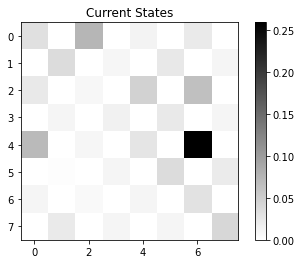

Position qubits: {'000001': 0.07238, '000011': 0.01017, '000101': 0.03265, '000111': 0.01666, '001000': 0.00756, '001010': 0.05619, '001100': 0.02221, '001110': 0.00589, '010001': 0.01873, '010011': 0.02649, '010101': 0.00241, '010111': 0.07118, '011000': 0.01231, '011010': 0.01017, '011100': 0.03238, '011110': 0.04335, '100001': 0.05405, '100011': 0.01017, '100101': 0.05619, '100111': 0.16464, '101000': 0.02549, '101010': 0.00589, '101100': 0.01124, '101110': 0.09272, '110001': 0.00836, '110011': 0.01552, '110101': 0.0006, '110111': 0.02101, '111000': 0.01084, '111010': 0.03298, '111100': 0.01231, '111110': 0.03726}
Data: [[0.      0.07238 0.      0.01017 0.      0.03265 0.      0.01666]
 [0.00756 0.      0.05619 0.      0.02221 0.      0.00589 0.     ]
 [0.      0.01873 0.      0.02649 0.      0.00241 0.      0.07118]
 [0.01231 0.      0.01017 0.      0.03238 0.      0.04335 0.     ]
 [0.      0.05405 0.      0.01017 0.      0.05619 0.      0.16464]
 [0.02549 0.      0.00589 0.      

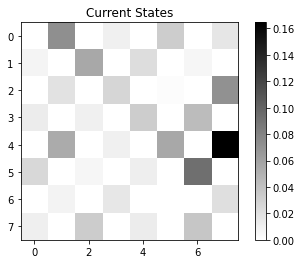

Position qubits: {'000000': 0.03576, '000010': 0.01346, '000100': 0.00729, '000110': 0.04887, '001001': 0.03721, '001011': 0.04589, '001101': 0.00415, '001111': 0.01542, '010000': 0.05728, '010010': 0.00595, '010100': 0.02649, '010110': 0.01478, '011001': 0.01017, '011011': 0.02823, '011101': 0.04268, '011111': 0.03387, '100000': 0.06412, '100010': 0.03265, '100100': 0.01345, '100110': 0.12331, '101001': 0.02639, '101011': 0.00375, '101101': 0.01487, '101111': 0.08018, '110000': 0.02532, '110010': 0.02385, '110100': 0.02959, '110110': 0.07041, '111001': 0.04004, '111011': 0.01019, '111101': 0.00512, '111111': 0.00927}
Data: [[0.03576 0.      0.01346 0.      0.00729 0.      0.04887 0.     ]
 [0.      0.03721 0.      0.04589 0.      0.00415 0.      0.01542]
 [0.05728 0.      0.00595 0.      0.02649 0.      0.01478 0.     ]
 [0.      0.01017 0.      0.02823 0.      0.04268 0.      0.03387]
 [0.06412 0.      0.03265 0.      0.01345 0.      0.12331 0.     ]
 [0.      0.02639 0.      0.00375

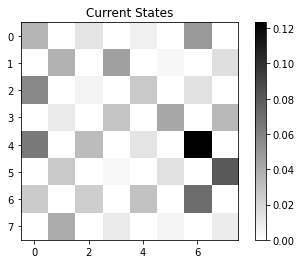

Position qubits: {'000001': 0.0258, '000011': 0.0299, '000101': 0.01116, '000111': 0.00353, '001000': 0.05943, '001010': 0.02866, '001100': 0.00778, '001110': 0.00679, '010001': 0.00786, '010011': 0.01224, '010101': 0.02595, '010111': 0.04083, '011000': 0.01191, '011010': 0.00961, '011100': 0.0616, '011110': 0.04402, '100001': 0.03353, '100011': 0.02581, '100101': 0.00928, '100111': 0.01952, '101000': 0.09332, '101010': 0.01773, '101100': 0.03419, '101110': 0.13916, '110001': 0.01715, '110011': 0.0188, '110101': 0.0076, '110111': 0.08289, '111000': 0.03381, '111010': 0.01007, '111100': 0.01198, '111110': 0.05812}
Data: [[0.      0.0258  0.      0.0299  0.      0.01116 0.      0.00353]
 [0.05943 0.      0.02866 0.      0.00778 0.      0.00679 0.     ]
 [0.      0.00786 0.      0.01224 0.      0.02595 0.      0.04083]
 [0.01191 0.      0.00961 0.      0.0616  0.      0.04402 0.     ]
 [0.      0.03353 0.      0.02581 0.      0.00928 0.      0.01952]
 [0.09332 0.      0.01773 0.      0.03

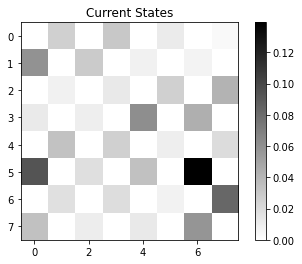

Position qubits: {'000000': 0.00329, '000010': 0.00904, '000100': 0.02294, '000110': 0.02363, '001001': 0.05675, '001011': 0.03042, '001101': 0.00315, '001111': 0.01861, '010000': 0.01365, '010010': 0.01289, '010100': 0.01224, '010110': 0.0321, '011001': 0.00943, '011011': 0.01477, '011101': 0.0617, '011111': 0.06286, '100000': 0.00667, '100010': 0.03087, '100100': 0.01843, '100110': 0.01987, '101001': 0.08815, '101011': 0.01201, '101101': 0.03621, '101111': 0.11237, '110000': 0.06368, '110010': 0.02024, '110100': 0.04376, '110110': 0.02852, '111001': 0.03836, '111011': 0.01882, '111101': 0.00309, '111111': 0.0715}
Data: [[0.00329 0.      0.00904 0.      0.02294 0.      0.02363 0.     ]
 [0.      0.05675 0.      0.03042 0.      0.00315 0.      0.01861]
 [0.01365 0.      0.01289 0.      0.01224 0.      0.0321  0.     ]
 [0.      0.00943 0.      0.01477 0.      0.0617  0.      0.06286]
 [0.00667 0.      0.03087 0.      0.01843 0.      0.01987 0.     ]
 [0.      0.08815 0.      0.01201 0.

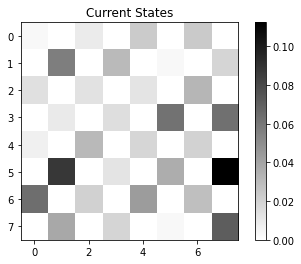

Position qubits: {'000001': 0.0201, '000011': 0.0366, '000101': 0.00609, '000111': 0.01248, '001000': 0.03205, '001010': 0.0418, '001100': 0.00553, '001110': 0.02281, '010001': 0.0172, '010011': 0.02635, '010101': 0.01394, '010111': 0.02369, '011000': 0.06983, '011010': 0.00407, '011100': 0.02907, '011110': 0.02069, '100001': 0.0027, '100011': 0.04776, '100101': 0.07766, '100111': 0.00741, '101000': 0.14044, '101010': 0.05697, '101100': 0.01943, '101110': 0.04163, '110001': 0.02844, '110011': 0.02222, '110101': 0.02984, '110111': 0.04422, '111000': 0.052, '111010': 0.01053, '111100': 0.02869, '111110': 0.00778}
Data: [[0.      0.0201  0.      0.0366  0.      0.00609 0.      0.01248]
 [0.03205 0.      0.0418  0.      0.00553 0.      0.02281 0.     ]
 [0.      0.0172  0.      0.02635 0.      0.01394 0.      0.02369]
 [0.06983 0.      0.00407 0.      0.02907 0.      0.02069 0.     ]
 [0.      0.0027  0.      0.04776 0.      0.07766 0.      0.00741]
 [0.14044 0.      0.05697 0.      0.0194

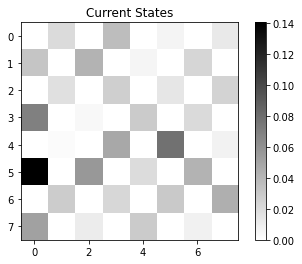

Position qubits: {'000000': 0.05751, '000010': 0.05568, '000100': 0.00601, '000110': 0.01021, '001001': 0.025, '001011': 0.00292, '001101': 0.00297, '001111': 0.02678, '010000': 0.02247, '010010': 0.01016, '010100': 0.02501, '010110': 0.02463, '011001': 0.04644, '011011': 0.00578, '011101': 0.08109, '011111': 0.01062, '100000': 0.00651, '100010': 0.00206, '100100': 0.09257, '100110': 0.01091, '101001': 0.04616, '101011': 0.04165, '101101': 0.01688, '101111': 0.0652, '110000': 0.10766, '110010': 0.02621, '110100': 0.0344, '110110': 0.00697, '111001': 0.03723, '111011': 0.01497, '111101': 0.01554, '111111': 0.06182}
Data: [[0.05751 0.      0.05568 0.      0.00601 0.      0.01021 0.     ]
 [0.      0.025   0.      0.00292 0.      0.00297 0.      0.02678]
 [0.02247 0.      0.01016 0.      0.02501 0.      0.02463 0.     ]
 [0.      0.04644 0.      0.00578 0.      0.08109 0.      0.01062]
 [0.00651 0.      0.00206 0.      0.09257 0.      0.01091 0.     ]
 [0.      0.04616 0.      0.04165 0. 

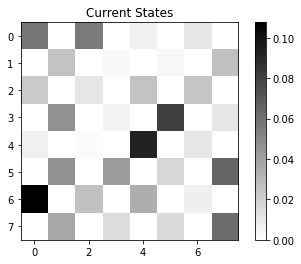

Position qubits: {'000001': 0.10533, '000011': 0.04582, '000101': 0.01134, '000111': 0.00988, '001000': 0.03311, '001010': 0.00133, '001100': 0.01752, '001110': 0.00558, '010001': 0.03602, '010011': 0.00828, '010101': 0.01418, '010111': 0.01844, '011000': 0.02044, '011010': 0.0185, '011100': 0.01375, '011110': 0.01836, '100001': 0.01421, '100011': 0.00777, '100101': 0.18607, '100111': 0.00893, '101000': 0.05715, '101010': 0.02917, '101100': 0.02095, '101110': 0.00702, '110001': 0.08213, '110011': 0.03507, '110101': 0.02391, '110111': 0.08086, '111000': 0.0239, '111010': 0.02211, '111100': 0.0102, '111110': 0.01267}
Data: [[0.      0.10533 0.      0.04582 0.      0.01134 0.      0.00988]
 [0.03311 0.      0.00133 0.      0.01752 0.      0.00558 0.     ]
 [0.      0.03602 0.      0.00828 0.      0.01418 0.      0.01844]
 [0.02044 0.      0.0185  0.      0.01375 0.      0.01836 0.     ]
 [0.      0.01421 0.      0.00777 0.      0.18607 0.      0.00893]
 [0.05715 0.      0.02917 0.      0.

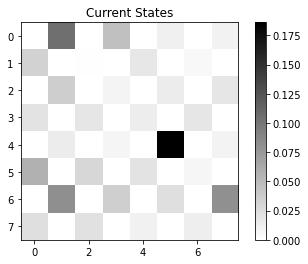

Position qubits: {'000000': 0.01755, '000010': 0.11775, '000100': 0.03042, '000110': 0.00771, '001001': 0.00287, '001011': 0.007, '001101': 0.00806, '001111': 0.01401, '010000': 0.0368, '010010': 0.03859, '010100': 0.01762, '010110': 0.00933, '011001': 0.01161, '011011': 0.01126, '011101': 0.01021, '011111': 0.0163, '100000': 0.02463, '100010': 0.01938, '100100': 0.04536, '100110': 0.1494, '101001': 0.00804, '101011': 0.02297, '101101': 0.03744, '101111': 0.06418, '110000': 0.082, '110010': 0.09548, '110100': 0.00737, '110110': 0.01015, '111001': 0.02668, '111011': 0.03239, '111101': 0.00488, '111111': 0.01255}
Data: [[0.01755 0.      0.11775 0.      0.03042 0.      0.00771 0.     ]
 [0.      0.00287 0.      0.007   0.      0.00806 0.      0.01401]
 [0.0368  0.      0.03859 0.      0.01762 0.      0.00933 0.     ]
 [0.      0.01161 0.      0.01126 0.      0.01021 0.      0.0163 ]
 [0.02463 0.      0.01938 0.      0.04536 0.      0.1494  0.     ]
 [0.      0.00804 0.      0.02297 0.    

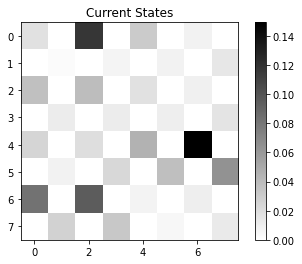

Position qubits: {'000001': 0.07977, '000011': 0.02166, '000101': 0.00692, '000111': 0.00146, '001000': 0.01578, '001010': 0.01968, '001100': 0.01929, '001110': 0.00686, '010001': 0.02537, '010011': 0.02863, '010101': 0.0059, '010111': 0.02341, '011000': 0.01614, '011010': 0.01994, '011100': 0.03539, '011110': 0.06219, '100001': 0.04419, '100011': 0.02133, '100101': 0.06469, '100111': 0.04, '101000': 0.00402, '101010': 0.00455, '101100': 0.02858, '101110': 0.05942, '110001': 0.08429, '110011': 0.0754, '110101': 0.0053, '110111': 0.05773, '111000': 0.00597, '111010': 0.07633, '111100': 0.03043, '111110': 0.00937}
Data: [[0.      0.07977 0.      0.02166 0.      0.00692 0.      0.00146]
 [0.01578 0.      0.01968 0.      0.01929 0.      0.00686 0.     ]
 [0.      0.02537 0.      0.02863 0.      0.0059  0.      0.02341]
 [0.01614 0.      0.01994 0.      0.03539 0.      0.06219 0.     ]
 [0.      0.04419 0.      0.02133 0.      0.06469 0.      0.04   ]
 [0.00402 0.      0.00455 0.      0.028

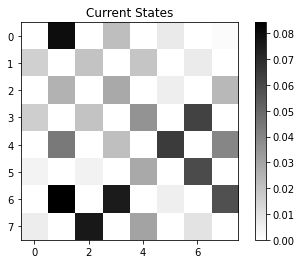

Position qubits: {'000000': 0.01827, '000010': 0.0878, '000100': 0.01074, '000110': 0.00763, '001001': 0.07871, '001011': 0.01707, '001101': 0.01355, '001111': 0.02244, '010000': 0.01885, '010010': 0.00163, '010100': 0.04169, '010110': 0.03017, '011001': 0.01009, '011011': 0.03536, '011101': 0.01479, '011111': 0.02493, '100000': 0.00728, '100010': 0.04152, '100100': 0.02086, '100110': 0.09114, '101001': 0.01283, '101011': 0.04059, '101101': 0.03215, '101111': 0.05327, '110000': 0.04738, '110010': 0.05111, '110100': 0.04635, '110110': 0.01588, '111001': 0.05089, '111011': 0.03507, '111101': 0.01259, '111111': 0.00737}
Data: [[0.01827 0.      0.0878  0.      0.01074 0.      0.00763 0.     ]
 [0.      0.07871 0.      0.01707 0.      0.01355 0.      0.02244]
 [0.01885 0.      0.00163 0.      0.04169 0.      0.03017 0.     ]
 [0.      0.01009 0.      0.03536 0.      0.01479 0.      0.02493]
 [0.00728 0.      0.04152 0.      0.02086 0.      0.09114 0.     ]
 [0.      0.01283 0.      0.04059 

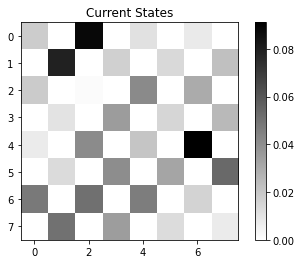

Position qubits: {'111111': 1.0}
Data: [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


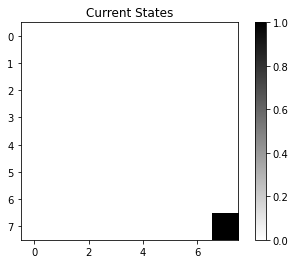

Position qubits: {'000000': 0.00141, '000010': 0.0612, '000100': 0.0155, '000110': 0.01183, '001001': 0.05695, '001011': 0.08531, '001101': 0.03475, '001111': 0.02275, '010000': 0.00847, '010010': 0.00312, '010100': 0.02081, '010110': 0.00698, '011001': 0.06534, '011011': 0.02899, '011101': 0.03391, '011111': 0.00453, '100000': 0.03424, '100010': 0.03122, '100100': 0.02736, '100110': 0.05177, '101001': 0.0056, '101011': 0.01338, '101101': 0.01864, '101111': 0.08171, '110000': 0.04584, '110010': 0.00552, '110100': 0.08606, '110110': 0.00745, '111001': 0.03654, '111011': 0.06531, '111101': 0.02033, '111111': 0.0072}
Data: [[0.00141 0.      0.0612  0.      0.0155  0.      0.01183 0.     ]
 [0.      0.05695 0.      0.08531 0.      0.03475 0.      0.02275]
 [0.00847 0.      0.00312 0.      0.02081 0.      0.00698 0.     ]
 [0.      0.06534 0.      0.02899 0.      0.03391 0.      0.00453]
 [0.03424 0.      0.03122 0.      0.02736 0.      0.05177 0.     ]
 [0.      0.0056  0.      0.01338 0. 

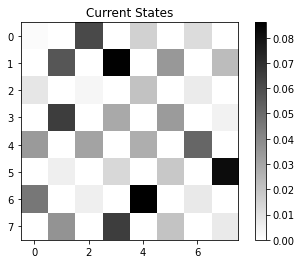

In [16]:
def round_remove_zeroes(np_dict):
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            d[k] = round(v, 5)
    
    new_dict = {}
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            if v:
                new_dict[k] = v
                
    return new_dict

# PLOTTING FOR 8 x 8 GRID
sum_data = np.zeros((8,8))
meta_states = []

for state in states:
    
    np_dict = round_remove_zeroes(np.array(state.probabilities_dict([7,6,5,4,3,2])))         
    print("Position qubits:",np_dict)
    
    data = np.around(np.array(state.probabilities([7,6,5,4,3,2])), 5)
    data = np.reshape(data, (8,8))
    sum_data = sum_data + data
    meta_states.append(sum_data)
    d = state.probabilities_dict([7,6,5,4,3,2])
    
    # customizing plot
    plt.title("Current States")
    pixel_plot = plt.imshow(
      data, cmap='binary')

    plt.colorbar(pixel_plot)
    
    print("Data:",data)
    plt.show(pixel_plot)
    
